## Sales Prediction

### Importing  Libs

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns
import plotly.io as pio
from IPython.display import Image
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import pickle # Read and Save model - Serialization
import sys
import os
from datetime import datetime
%matplotlib inline


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)
colors = ['#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF',
          '#FECB52', '#636EFA', '#EF553B', '#00CC96', '#AB63FA', ]

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler

In [5]:
file_handler = FileHandler()
#import util
#import plots

In [10]:
train_store_file = pd.read_csv('../data/merged_train.csv') 


#### Preprocessing

In [11]:
train_store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824541 entries, 0 to 824540
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      824541 non-null  int64  
 1   DayOfWeek                  824541 non-null  int64  
 2   Sales                      824541 non-null  float64
 3   Customers                  824541 non-null  float64
 4   Open                       824541 non-null  int64  
 5   Promo                      824541 non-null  int64  
 6   StateHoliday               824541 non-null  object 
 7   SchoolHoliday              824541 non-null  int64  
 8   year                       824541 non-null  int64  
 9   month                      824541 non-null  int64  
 10  day                        824541 non-null  int64  
 11  weekOfYear                 824541 non-null  int64  
 12  dayOfWeek                  824541 non-null  int64  
 13  StoreType                  82

In [12]:
## Lable Date and StateHoiday Train
columns = ['Sales','Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'day', 'weekOfYear','month', 'year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'day', 'weekOfYear','month', 'year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

sample_size = 1000
sampled_df = train_store_df[columns].sample(sample_size)


## Separet Test and train files
train_x = sampled_df[feature_columns]
train_y = sampled_df[['Sales']]
train_x.head()


NameError: name 'train_store_df' is not defined

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 40167 to 394692
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1000 non-null   int64  
 1   DayOfWeek            1000 non-null   int64  
 2   Open                 1000 non-null   int64  
 3   Promo                1000 non-null   int64  
 4   SchoolHoliday        1000 non-null   int64  
 5   day                  1000 non-null   int64  
 6   weekOfYear           1000 non-null   int64  
 7   month                1000 non-null   int64  
 8   year                 1000 non-null   int64  
 9   StoreType            1000 non-null   int32  
 10  Assortment           1000 non-null   int32  
 11  CompetitionDistance  1000 non-null   float64
 12  Promo2               1000 non-null   int64  
dtypes: float64(1), int32(2), int64(10)
memory usage: 101.6 KB


In [165]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# X = x_scaler.fit_transform(train_x)
X = train_x
Y = y_scaler.fit_transform(train_y)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [167]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [168]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 26.48%


In [169]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
   




### Building models with sklearn pipelines

In [10]:
feat_imp = pd.DataFrame({'FeatureImportance': model.feature_importances_})
feat_imp['Feature'] = feature_columns
feat_imp = feat_imp.sort_values(by=['Feature Importance'], ascending=False)
#feat_imp

AttributeError: 'NoneType' object has no attribute 'feature_importances_'

In [171]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler3',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dt_regretion',
                 DecisionTreeRegressor(criterion='mse', max_depth=None,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=0,
                                       splitter='best'))],
         verbose=False)

In [172]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"Prediction Score of the RandomForestRegretion is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegretion is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTree is {round(dt_score * 100, 2)}%")

# print(rfr_score)

Prediction Score of the RandomForestRegretion is 35.49%
Prediction Score of the LinearRegretion is 31.6%
Prediction Score of the DecisionTree is -19.94%


### Choose a loss function

In [173]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse, rft_mae, _ = util.eval_metrics(y_test, rfr_prediction)
lr_rmse, lr_mae, _ = util.eval_metrics(y_test, lr_prediction)
dt_rmse, dt_mae, _ = util.eval_metrics(y_test, dt_prediction)


# print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")
print(f"RandomForest Mean Square Loss : {rfr_rmse}")
print(f"Linear Mean Square Loss : {lr_rmse}")
print(f"DecisionTree Mean Square Loss : {dt_rmse }%")

RandomForest Mean Square Loss : 2060.979042042678
Linear Mean Square Loss : 2122.2905490105677
DecisionTree Mean Square Loss : 2810.2548614405064%


#### Post Prediction Analysis

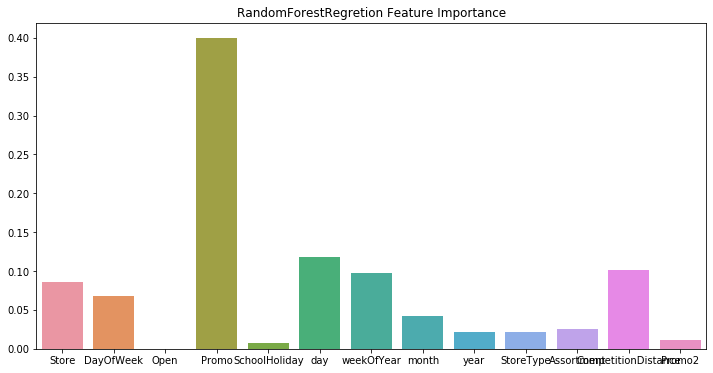

In [174]:
important_features = rfr[1].feature_importances_
plots.bar(feature_columns, important_features, 'RandomForestRegretion Feature Importance')


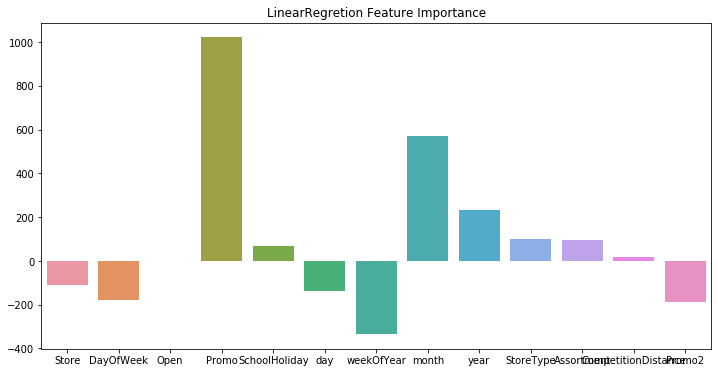

In [175]:
important_features = lr[1].coef_[0]
from matplotlib import pyplot as plt
plots.bar(feature_columns, list(important_features), "LinearRegretion Feature Importance")

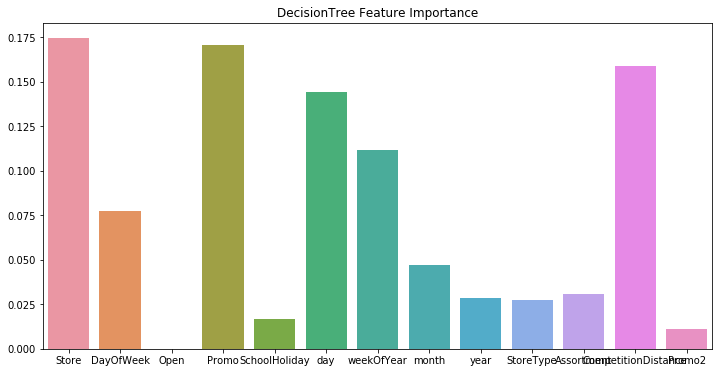

In [176]:
important_features = dt[1].feature_importances_
plots.bar(feature_columns, important_features ,"DecisionTree Feature Importance")

#### Serialize models

In [177]:
## use picke to dump mode
## decomment picke to save the model

reg_model_file_name = f'../models/reg-{datetime.now()}.pkl'
lr_model_file_name = f'../models/lt-{datetime.now()}.pkl'
dt_model_file_name = f'../models/dt-{datetime.now()}.pkl'

files = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

print(reg_model_file_name)
print(lr_model_file_name)
print(dt_model_file_name)




../models/reg-2022-05-29 20:39:54.401371.pkl
../models/lt-2022-05-29 20:39:54.401371.pkl
../models/dt-2022-05-29 20:39:54.401371.pkl


In [179]:
dt_file = '../models/reg-2022-05-29 20:39:54.401371.pkl'
lr_file = '../models/lt-2022-05-29 20:39:54.401371.pkl'
model = pickle.load(open(lr_file, 'rb'))

OSError: [Errno 22] Invalid argument: '../models/lt-2022-05-29 20:39:54.401371.pkl'

In [155]:
score = model.score(X_test, y_test)
score

NameError: name 'model' is not defined

#### Post Prediction analysis

#### In the EDA part we have already clean and remove the outliers. for the main features  and preparing the for training , there is a create for it prepared in create_features.py file

In [180]:
train_features = file_handler.read_csv("../features/train_features.csv")
test_features = file_handler.read_csv("../features/test_features.csv")
train_sales = file_handler.read_csv("../features/train_sales.csv")
train_customers = file_handler.read_csv("../features/train_customers.csv")

AttributeError: 'function' object has no attribute 'exception'

In [7]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824541 entries, 0 to 824540
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   DayOfWeek                  824541 non-null  int64  
 1   Promo                      824541 non-null  int64  
 2   StateHoliday               824541 non-null  object 
 3   SchoolHoliday              824541 non-null  int64  
 4   Unnamed: 0                 824541 non-null  int64  
 5   StoreType                  824541 non-null  object 
 6   Assortment                 824541 non-null  object 
 7   CompetitionDistance        824541 non-null  float64
 8   Promo2                     824541 non-null  int64  
 9   PromoInterval0             824541 non-null  int64  
 10  PromoInterval1             824541 non-null  int64  
 11  PromoInterval2             824541 non-null  int64  
 12  PromoInterval3             824541 non-null  int64  
 13  days_before_state_holiday  82

#### the main feature for predictions are listed above

In [8]:
train_df = file_handler.read_csv("../data/train.csv")

In [9]:
sales_data = train_df.groupby("Date").agg({"Sales": "mean"})[:100].copy()


In [10]:
sales_data

,Sales
Date,
2013-01-01,87.28
2013-01-02,6233.03
2013-01-03,5693.11
2013-01-04,5954.22
2013-01-05,5337.75
...,...
2013-04-06,5534.58
2013-04-07,169.59
2013-04-08,9072.29


In [99]:
feature_columns = [x for x in train_features]

NameError: name 'train_features' is not defined

feature_columns are the main features selected for prediction.

### Random Forest Regressor

In [98]:
random_model = file_handler.read_model("RandomForestRegressor-sales-2021-08-01-20:17")

AttributeError: 'function' object has no attribute 'exception'

In [11]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(sales_data)
sales_data['DataScaled'] = scaled_array

In [41]:
WINDOW_SIZE = 48
BATCH_SIZE =  len(sales_data.DataScaled) - WINDOW_SIZE * 2
EPOCHS = 200

In [42]:
DateTrain = sales_data.index.values[0:BATCH_SIZE]
DateValid = sales_data.index.values[BATCH_SIZE:]
XTrain = sales_data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales_data.DataScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)


Shape of the training set date series:  (4, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (4,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


#### Random Forest Regressor

In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dms(XTrain, axis=-1)
series.shape

In [ ]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

In [ ]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [ ]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))